# Preparation des données

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import MissingIndicator, KNNImputer,SimpleImputer
from sklearn.impute import IterativeImputer
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest
import seaborn as sns

In [2]:
df2 = pd.read_excel("C:/Users/hp/Downloads/projet/nov-22.xlsx",keep_default_na=True, header=0)

In [3]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219827 entries, 0 to 219826
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   co_id               219827 non-null  int64  
 1   activation_date     219827 non-null  object 
 2   total_nb_recharge   194854 non-null  float64
 3   total_rechage       194854 non-null  float64
 4   total_u_data        178671 non-null  float64
 5   total_rev_option    115640 non-null  float64
 6   total_rev_sos       354 non-null     float64
 7   total_u_out         210208 non-null  float64
 8   total_u_in          153533 non-null  float64
 9   usage_op1           955 non-null     float64
 10  usage_op2           11301 non-null   float64
 11  usage_op3           139630 non-null  float64
 12  nb_cont_out         208896 non-null  float64
 13  nb_cont_in          208884 non-null  float64
 14  nb_cell_visite_out  208896 non-null  float64
 15  nb_cell_visite_in   208884 non-nul

# ➤ Doublons

In [4]:
duplicated_count = df2.duplicated().sum()
print(f"Nombre de lignes dupliquées : {duplicated_count}")


Nombre de lignes dupliquées : 1


In [5]:
print(df2[df2.duplicated()])


           co_id      activation_date  total_nb_recharge  total_rechage  \
139163  40151408  2022-11-18 13:25:36                1.0            1.0   

        total_u_data  total_rev_option  total_rev_sos  total_u_out  \
139163     99.672852               NaN            NaN       46.899   

        total_u_in  usage_op1  ...  usage_op3  nb_cont_out  nb_cont_in  \
139163       4.633        NaN  ...      2.233          5.0         3.0   

        nb_cell_visite_out  nb_cell_visite_in  entity_code entity_type_name  \
139163                 3.0                2.0      KAI0054         INDIRECT   

       nbr_contrat  nbr_actif  flag_churn  
139163        10.0        3.0           0  

[1 rows x 21 columns]


In [6]:
df2_cleaned = df2.drop_duplicates()


<Axes: ylabel='count'>

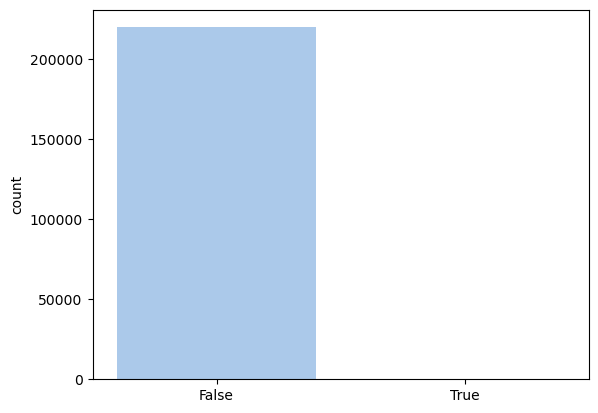

In [7]:
sns.countplot(x=df2.duplicated(), palette='pastel')


In [8]:
print(df2_cleaned.duplicated().sum())  


0


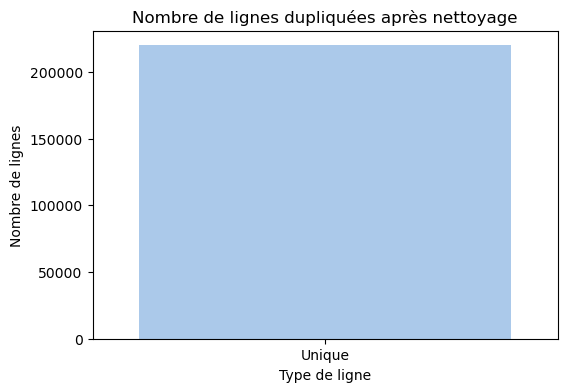

In [9]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df2_cleaned.duplicated(), palette='pastel')
plt.title("Nombre de lignes dupliquées après nettoyage")
plt.xticks([0], ['Unique'])  # Seulement une barre "Unique"
plt.ylabel("Nombre de lignes")
plt.xlabel("Type de ligne")
plt.show()


# ➤ Valeurs manquantes

In [10]:
df2.isnull().sum()

co_id                      0
activation_date            0
total_nb_recharge      24973
total_rechage          24973
total_u_data           41156
total_rev_option      104187
total_rev_sos         219473
total_u_out             9619
total_u_in             66294
usage_op1             218872
usage_op2             208526
usage_op3              80197
nb_cont_out            10931
nb_cont_in             10943
nb_cell_visite_out     10931
nb_cell_visite_in      10943
entity_code             4168
entity_type_name        4168
nbr_contrat             3894
nbr_actif               3894
flag_churn                 0
dtype: int64

# Suppression des colonnes avec plus de 90% de valeurs manquantes

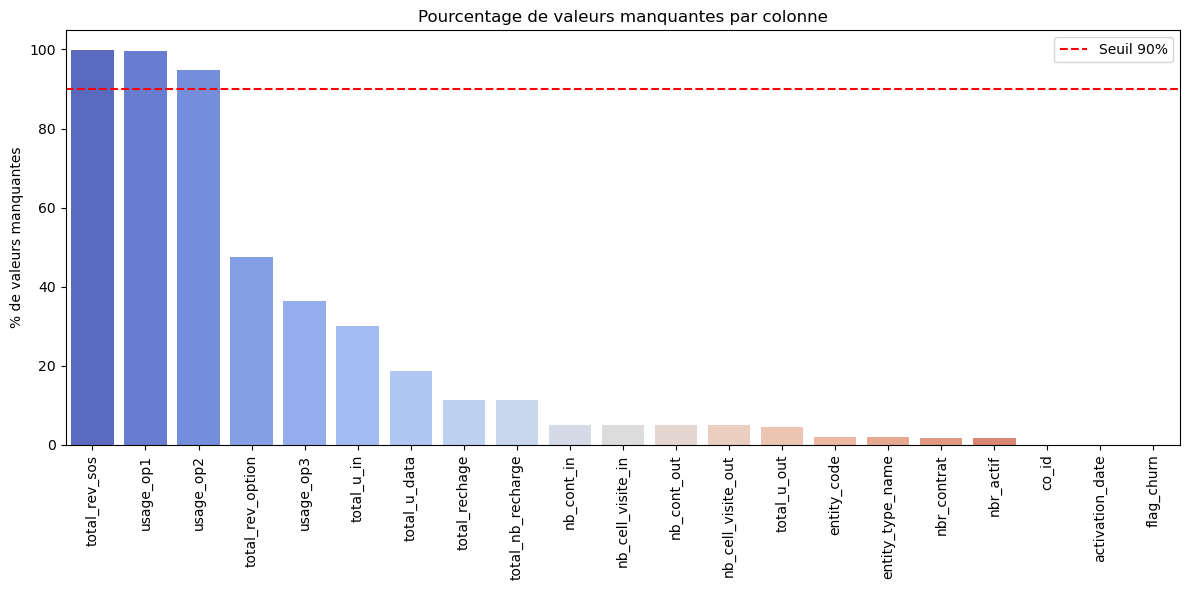

In [11]:
missing_percent = df2.isnull().mean() * 100

# Création du graphique
plt.figure(figsize=(12,6))
sns.barplot(
    x=missing_percent.sort_values(ascending=False).index,
    y=missing_percent.sort_values(ascending=False).values,
    palette="coolwarm"
)
plt.xticks(rotation=90)
plt.title("Pourcentage de valeurs manquantes par colonne")
plt.ylabel("% de valeurs manquantes")
plt.axhline(90, color='red', linestyle='--', label='Seuil 90%')
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
# Suppression des colonnes avec plus de 90% de valeurs manquantes
seuil = 0.9 * len(df2) 
df2_cleaned= df2.drop(columns=df2.columns[df2.isnull().sum() > seuil])

print("Colonnes restantes :", df2_cleaned.columns.tolist())



Colonnes restantes : ['co_id', 'activation_date', 'total_nb_recharge', 'total_rechage', 'total_u_data', 'total_rev_option', 'total_u_out', 'total_u_in', 'usage_op3', 'nb_cont_out', 'nb_cont_in', 'nb_cell_visite_out', 'nb_cell_visite_in', 'entity_code', 'entity_type_name', 'nbr_contrat', 'nbr_actif', 'flag_churn']


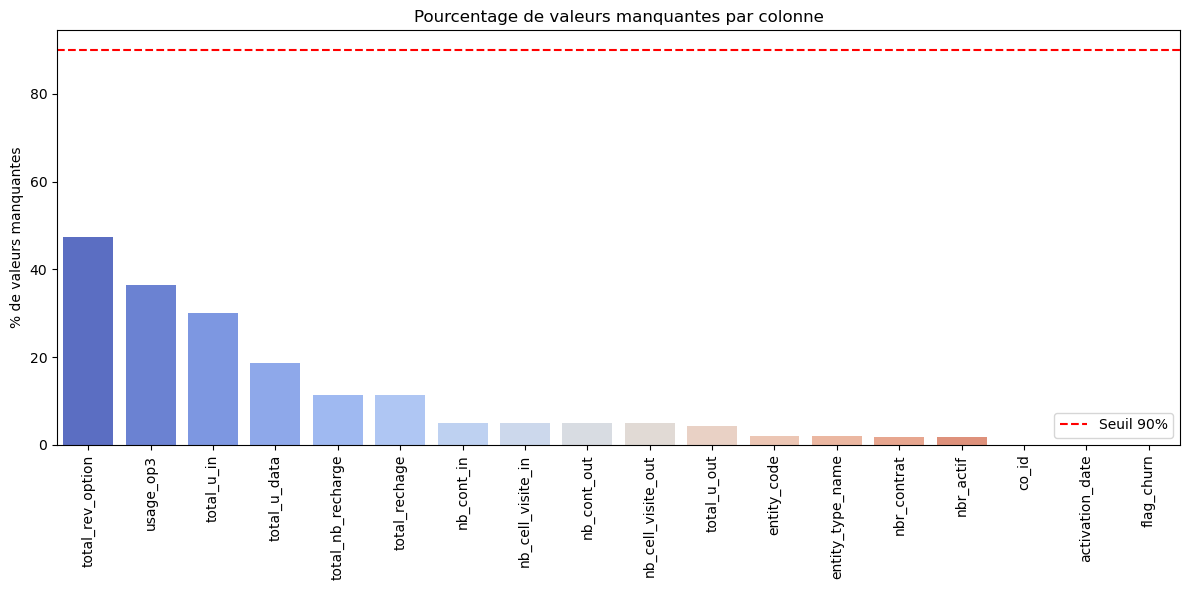

In [13]:
missing_percent = df2_cleaned.isnull().mean() * 100

plt.figure(figsize=(12,6))
sns.barplot(
    x=missing_percent.sort_values(ascending=False).index,
    y=missing_percent.sort_values(ascending=False).values,
    palette="coolwarm"
)
plt.xticks(rotation=90)
plt.title("Pourcentage de valeurs manquantes par colonne")
plt.ylabel("% de valeurs manquantes")
plt.axhline(90, color='red', linestyle='--', label='Seuil 90%')
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
cols_zero_fill = [
    'total_nb_recharge', 'total_rechage', 'total_u_data', 
    'total_rev_option', 'total_u_out', 
    'total_u_in', 'usage_op3',
    'nb_cont_out', 'nb_cont_in', 'nb_cell_visite_out', 
    'nb_cell_visite_in', 'nbr_contrat','nbr_actif'
]


missing_before = df2[cols_zero_fill].isna().sum()
missing_before


total_nb_recharge      24973
total_rechage          24973
total_u_data           41156
total_rev_option      104187
total_u_out             9619
total_u_in             66294
usage_op3              80197
nb_cont_out            10931
nb_cont_in             10943
nb_cell_visite_out     10931
nb_cell_visite_in      10943
nbr_contrat             3894
nbr_actif               3894
dtype: int64

In [15]:
df2_cleaned[cols_zero_fill] = df2[cols_zero_fill].fillna(0)
missing_after = df2_cleaned[cols_zero_fill].isna().sum()
missing_after

total_nb_recharge     0
total_rechage         0
total_u_data          0
total_rev_option      0
total_u_out           0
total_u_in            0
usage_op3             0
nb_cont_out           0
nb_cont_in            0
nb_cell_visite_out    0
nb_cell_visite_in     0
nbr_contrat           0
nbr_actif             0
dtype: int64

In [16]:
df2_cleaned.isnull().sum()

co_id                    0
activation_date          0
total_nb_recharge        0
total_rechage            0
total_u_data             0
total_rev_option         0
total_u_out              0
total_u_in               0
usage_op3                0
nb_cont_out              0
nb_cont_in               0
nb_cell_visite_out       0
nb_cell_visite_in        0
entity_code           4168
entity_type_name      4168
nbr_contrat              0
nbr_actif                0
flag_churn               0
dtype: int64

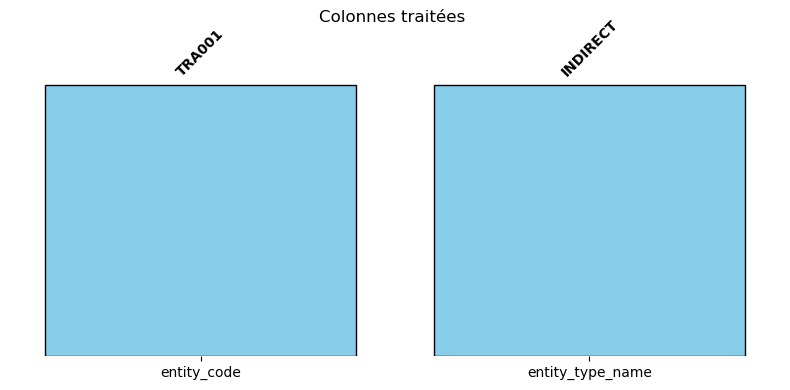

In [17]:
# Liste des colonnes catégorielles traitées
categorical_cols = ['entity_code', 'entity_type_name']

modes_used = {}

for col in categorical_cols:
    mode_value = df2[col].mode()[0]
    df2_cleaned[col] = df2[col].fillna(mode_value)
    modes_used[col] = mode_value
    
plt.figure(figsize=(8, 4))
bars = plt.bar(modes_used.keys(), [1]*len(modes_used), color='skyblue', edgecolor='black')

for bar, col in zip(bars, modes_used.keys()):
    plt.text(bar.get_x() + bar.get_width() / 2, 1.02, f"{modes_used[col]}", 
             ha='center', va='bottom', fontsize=10, fontweight='bold', rotation=45)

plt.ylim(0, 1.2)
plt.title("Colonnes traitées ")
plt.xticks(rotation=0)
plt.yticks([])
plt.box(False)
plt.tight_layout()
plt.show()


In [18]:
df2_cleaned.isnull().sum()

co_id                 0
activation_date       0
total_nb_recharge     0
total_rechage         0
total_u_data          0
total_rev_option      0
total_u_out           0
total_u_in            0
usage_op3             0
nb_cont_out           0
nb_cont_in            0
nb_cell_visite_out    0
nb_cell_visite_in     0
entity_code           0
entity_type_name      0
nbr_contrat           0
nbr_actif             0
flag_churn            0
dtype: int64

# Garder uniquement la date

In [19]:
df2_cleaned['activation_date'] = pd.to_datetime(df2['activation_date'])
df2_cleaned['activation_date'] = df2_cleaned['activation_date'].dt.date
df2_cleaned['activation_date'] 

0         2022-11-16
1         2022-11-16
2         2022-11-04
3         2022-11-20
4         2022-11-01
             ...    
219822    2022-11-21
219823    2022-11-02
219824    2022-11-03
219825    2022-11-02
219826    2022-11-17
Name: activation_date, Length: 219827, dtype: object

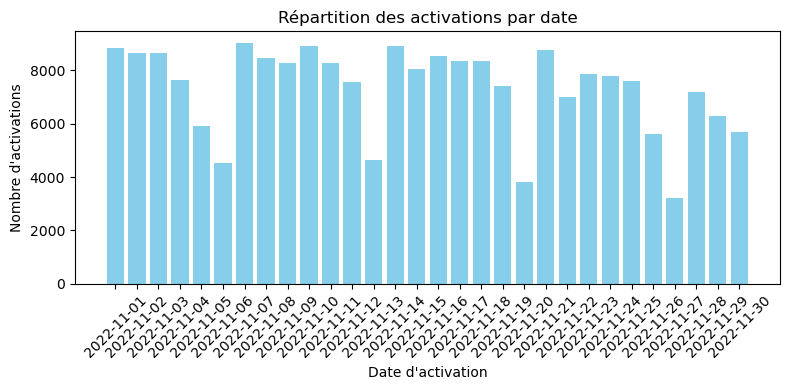

In [20]:
activation_counts = df2_cleaned['activation_date'].value_counts().sort_index()

plt.figure(figsize=(8, 4))
plt.bar(activation_counts.index.astype(str), activation_counts.values, color='skyblue')
plt.title("Répartition des activations par date")
plt.xlabel("Date d'activation")
plt.ylabel("Nombre d'activations")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Remplacement des codes numériques par des étiquettes textuelles

In [21]:
df2_cleaned['flag_churn'] = df2['flag_churn'].replace({
    0: 'contrat encore actif',
    1: 'contrat résilié'
})


print(df2_cleaned['flag_churn'].value_counts())


contrat résilié         140614
contrat encore actif     79213
Name: flag_churn, dtype: int64


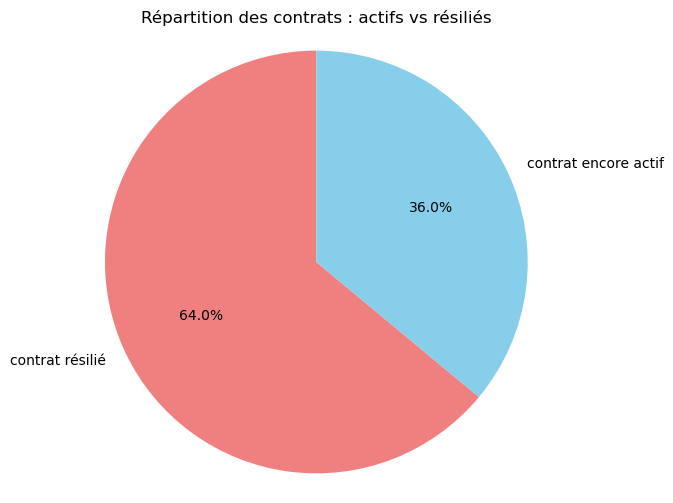

In [22]:
churn_counts = df2_cleaned['flag_churn'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    churn_counts.values,
    labels=churn_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['lightcoral', 'skyblue']
)
plt.title('Répartition des contrats : actifs vs résiliés')
plt.axis('equal')
plt.show()

In [23]:
# 3. 💾 Exporter le fichier Excel
df2_cleaned.to_excel('df2_traité.xlsx', index=False)

print("✅ Fichier exporté avec succès : df2_traité.xlsx")

✅ Fichier exporté avec succès : df2_traité.xlsx
